In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from numpy import pi

import pandas as pd
import emcee # a MCMC sampler
import corner
import dynesty # a nested sampler
from dynesty import plotting
plt.rcParams.update({'font.size': 12})
import scipy.optimize as opt
import random
import scipy
import copy 
from numba import jit, njit

The aim of this notebook is to demonstrate my knowledge of stochastic processes and hypothesis testing using a toy problem.

So the aim of the problem is to track a Bigfoot!:)

Imagine a 2d forest, partitioned into 100x100 squares. If Bigfoot passes through the forest, it does it in the following manner: Starting from the left, in each step, it moves either to one square right, right top, or right bottom. When it passes through a square, it will leave footprints in probability 70%. In squares it did not pass through, there is a 10% probability that footprints will appear randomly (this is also true if Bigfoot did not pass through the forest).

The notebook consists of 2 main parts:
1) Given a map of footprints, write a test that answers the question "Was there Bigfoot?"
2) Given a map of footprints, reconstruct Bigfoot's path.

# Part 0: preparation

In [218]:
p0 = 0.1 #probability of the random steps on the ground
p1 = 0.8 #probability of Bigfoot's footprints left

N = 100

#Assume pereodic b.c.

In [209]:
# Let Y be our map observation.
# Let X be 'true' Bigfoot's footprints

def give_YX(p0, p1, bigfoot = True):
    Y = np.zeros((N, N))
    X = np.zeros((N, N))
    route = np.zeros(N)
    start = int(np.random.rand()*N % N)
    if bigfoot:
        if np.random.rand() < p1:
            Y[start, 0] = 1
        i = start
        for j in range(1, N):
            move = int(np.random.rand()*3 % 3) - 1
            i = (i +move)%N
            X[i, j] = 1
            route[j] = i
            if np.random.rand() < p1:
                 Y[i, j] = 1

    for i in range(N):
        for j in range(N):
            if np.random.rand()< p0:
                Y[i, j] = 1
    return  Y, X, route

In [210]:
Y, X, route = give_YX(p0, p1)

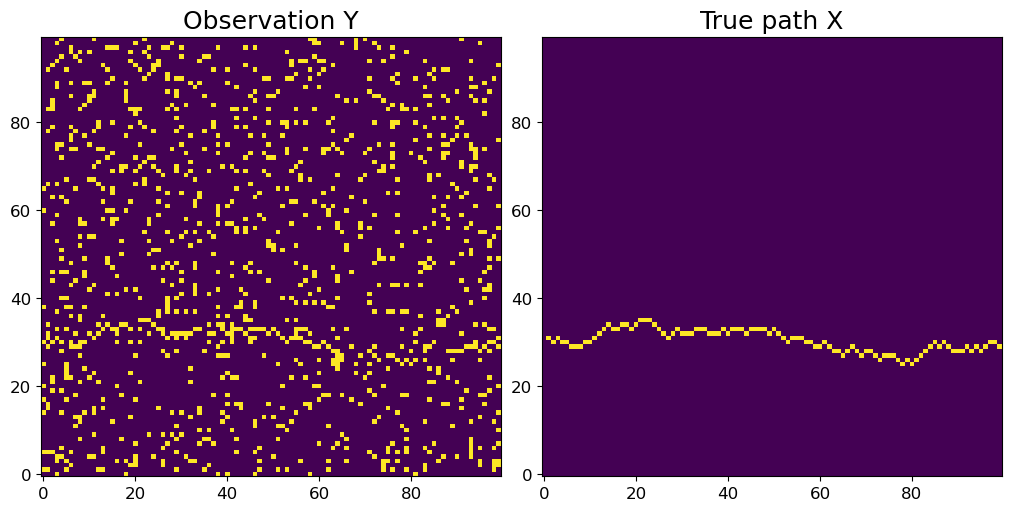

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax1, ax2 = axes

ax1.pcolormesh(Y, shading='nearest')
ax1.set_title('Observation Y',fontsize = 18)

ax2.pcolormesh(X, shading='nearest')
ax2.set_title('True path X',fontsize = 18)

plt.show()

# Part 1: detecting BigFoot's presence

The handwritten derivation of the test is in the pdf. Someday I will make latex version

In [212]:
#This is a modified transition matrix, see test derivation
def get_Td(p0, p1):
    pd = 1 - p1/(1 - p0)
    p= (1+p1/p0)/pd
    Td = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if (i == j) or (j == (i-1)%N) or (j == (i+1)%N):
                Td[i, j] = 1/3*pd
    return Td

In [213]:
Td = get_Td(p0, p1)

In [214]:
# Thi is a test itself
@njit
def Test(Y, Td, p01, p11):


    pd = 1 - p11/(1 - p01)
    p= (1+p11/p01)/pd
    # Initialize a table to store intermediate results
    probs =np.zeros(N)
    temp_arr = np.zeros(N)
    
    for i in range(N):
        probs[i]= 1 / N #starting poing with prob 1/p
    
   
    for step in range(1, N ):
        for k in range(N):
            temp = 0
            for i in range(k-1, k+2):
                i_d = i % N # cyclic boarder condition
                temp +=   probs[i_d] * Td[i_d, k] * p**Y[k, step]
            temp_arr[k] = temp
        probs = temp_arr.copy()
        
                
    
    return np.log(np.sum( probs))

In [215]:
#Here I simmulate test statistics under H0 (no bigfoot) and H1 (there is bigfoot)
n = 5000
stat0 = np.zeros(n) #Test statistics under H0
stat1 = np.zeros(n) #Test statistics under H1

for k in range(n):
    Y, _, _ = give_YX(p0, p1, bigfoot = False)        
    stat0[k] = Test(Y, Td, p0, p1)


    
    Y, _, _ = give_YX(p0, p1)        
    stat1[k] = Test(Y, Td, p0, p1)

In [216]:
hist0 = np.histogram(stat0,bins=50, density=True)
betta1 = 0.1 # Fixing betta1 error, we will find decision boundary
i0 = 2
for i in range(len(hist0[1])):
    if np.sum(hist0[0][i:]*(hist0[1][1] - hist0[1][0])) <= betta1:
        i0 = hist0[1][i]
        break
    

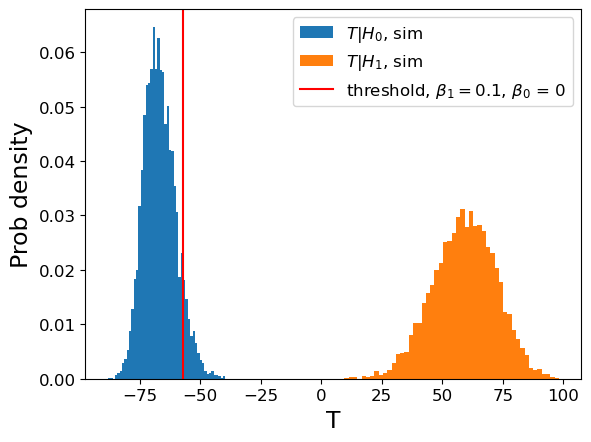

In [217]:
plt.hist(stat0,bins=50, density=True, label="$T|H_0$, sim")
plt.hist(stat1,bins=50, density=True, label="$T|H_1$, sim")
plt.axvline(i0, color = 'red', label="threshold, $\\beta_1 = $0.1, $\\beta_0$ = 0")
plt.xlabel("T", fontsize = 17)
plt.ylabel("Prob density", fontsize = 17)
#plt.xlim([0, 80])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()

# Part 2: detecting BigFoot's presence

In [220]:
def Verbeti(Y, Td, p01, p11):

    pd = 1 - p11/(1 - p01)
    p= (1+p11/p01)/pd
      # Initialize a table to store intermediate results
    probs = []
    temp_arr = np.zeros(N)
    subseqs = []
    
    for i in range(N):
        probs.append(1 / N) #starting poing with prob 1/p
        subseqs.append([i])
    
   
    for step in range(1, N ):
        temp_subseqs = [] # collect tempopary sequences with different old last letters
        temp_probs = [] # 
        for k in range(N):
            temp_probs_last = []
            for i in range(k-1, k+2):
                i_d = i % N # cyclic boarder condition
                temp_probs_last.append(probs[i_d] * Td[i_d, k] * p**Y[k, step])
            temp_probs.append(np.max(temp_probs_last)) # choosing the maximal probability
            temp_subseqs.append(subseqs[(np.argmax(temp_probs_last) + k -1)% N]+[k]) # making the subsentence with the maximal probability
        subseqs = copy.deepcopy(temp_subseqs) # saving the best result and running next
        probs = copy.deepcopy(temp_probs)
        
    
    return subseqs[np.argmax(probs)]

In [221]:
#As a metric of our tracking quality, we will usethe  average Distance between the predicted and actual Bigfoot path (L1 norm)
@njit
def dist(route, predict):
    d = 0
    for i in range(N):
        d += min(abs(N - np.abs(route[i] - predict[i])), np.abs(route[i] - predict[i]) ) #this form to take into account pereodic b.c.
    return d/N
        

In [222]:
#Simulation prediction quality statistics
n = 1000
dist_arr = np.zeros(n)
for m in range(n):
    Y, X, route = give_YX(p0, p1)
    dist_arr[m] = dist(route, Verbeti(Y,Td, p0, p1))

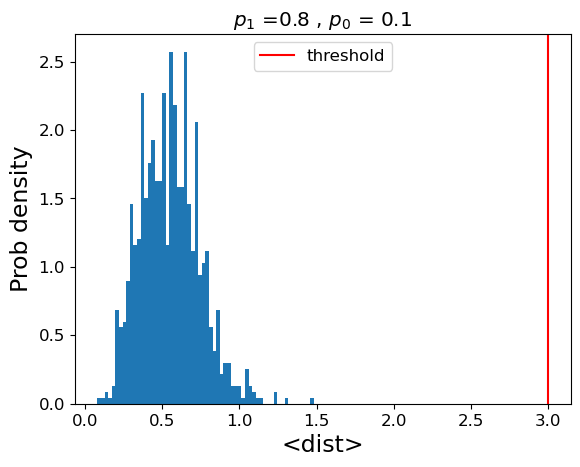

In [223]:
plt.hist(dist_arr,bins=60, density=True)

plt.xlabel("<dist>", fontsize = 17)
plt.ylabel("Prob density", fontsize = 17)
#plt.xlim([0, 80])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.axvline(3, color = 'red', label="threshold")  # Let us say that our prediction is bad if L1 norm is higher than 3
plt.title("$p_1$ =" + str(p1) + " , $p_0$ = " + str(p0))
plt.legend()


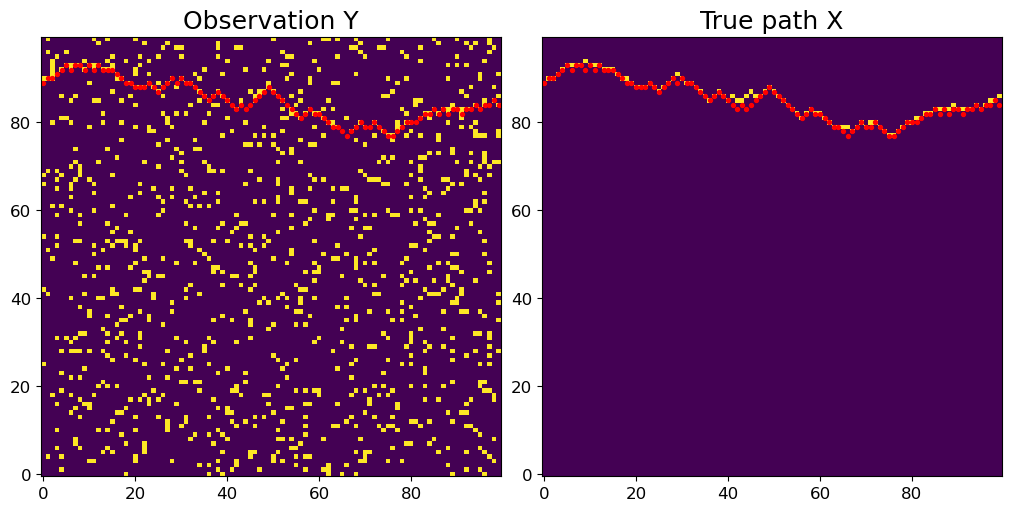

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax1, ax2 = axes

ax1.pcolormesh(Y, shading='nearest')
ax1.set_title('Observation Y',fontsize = 18)
ax1.scatter(np.linspace(0, N-1, N),Verbeti(Y, Td, p0, p1), s =8,color = 'red', label = 'Verbeti predict')

ax2.pcolormesh(X, shading='nearest')
ax2.set_title('True path X',fontsize = 18)
ax2.scatter(np.linspace(0, N-1, N),Verbeti(Y, Td, p0, p1), s =8,color = 'red', label = 'Verbeti predict')

plt.show()

# Part 3: detection and tracking efficiency with various $p_1$

In [ ]:
!pip install tqdm

In [227]:
from tqdm import tqdm

In [234]:
p1_arr = np.linspace(0, 0.7, 20)
b1steps = np.zeros(len(p1_arr))
n = 1000

for o in tqdm(range(len(p1_arr)), desc="Processing"):
    p1 = p1_arr[o]
    Td = get_Td(p0, p1)
    
 
    dist_arr = np.zeros(n)
    stat0 = np.zeros(n)
    stat1 = np.zeros(n)
    
    for k in range(n):
        Y, _, _ = give_YX(p0, p1, bigfoot = False)       
        stat0[k] = Test(Y, Td, p0, p1)

        Y, _, _ = give_YX(p0, p1)       
        stat1[k] = Test(Y, Td, p0, p1)
        
   
    hist0 = np.histogram(stat0,bins=50, density=True)
    hist1 = np.histogram(stat1,bins=50, density=True)
    betta0 = 0.1
    i0 = 0
    
    for x in range(len(hist0[1])):
        if np.sum(hist0[0][x:]*(hist0[1][1]-hist0[1][0])) <= betta0:
            i0 = hist0[1][x]
            break
    b = 0
    for v in range(len(hist1[0])):
        if hist1[1][v] < i0:
            b += (hist1[1][1]-hist1[1][0])*hist1[0][v]
    b1steps[o] = b

Processing: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [02:34<00:00,  7.74s/it]


In [241]:
p1_arr = np.linspace(0, 0.7, 20)
b0steps = np.zeros(len(p1_arr))

for o in tqdm(range(len(p1_arr)), desc="Processing"):
    p1 = p1_arr[o]
    Td = get_Td(p0, p1)
    
 
    dist_arr = np.zeros(n)
    for m in range(n):


        Y, X, route = give_YX(p0, p1)
        dist_arr[m] = dist(route, Verbeti(Y,Td, p0, p1))
    hist = np.histogram(dist_arr, bins=60, density=True)
    
    b = 0
    for v in range(len(hist[0])):
        if hist[1][v] >= 3:
            b += (hist[1][1]-hist[1][0])*hist[0][v]
    b0steps[o] = b

Processing: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [27:17<00:00, 81.90s/it]


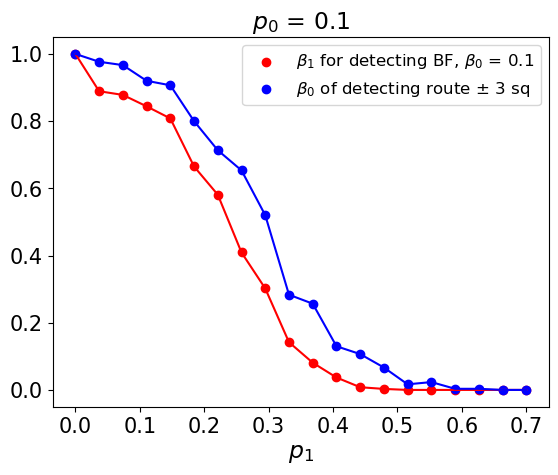

In [242]:
plt.plot(p1_arr,b1steps, color = 'red')
plt.scatter(p1_arr,b1steps, color = 'red', label = '$\\beta_1$ for detecting BF, $\\beta_0$ = 0.1')

plt.plot(p1_arr,b0steps, color = 'blue')
plt.scatter(p1_arr,b0steps, color = 'blue', label = '$\\beta_0$ of detecting route $\pm$ 3 sq')
plt.xlabel("$p_1$", fontsize = 17)
plt.title('$p_0$ = 0.1', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()